## Load data

The dataset is the adult dataset which can be downloaded from the UCI machine learning repository.

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

name_data = urlopen('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names')
lines = [l.decode("utf-8") for l in name_data if ':' in l.decode("utf-8") and '|' not in l.decode("utf-8")]

features = [l.split(':')[0] for l in lines]
label_name = 'income'

cat_features = [l.split(':')[0] for l in lines if 'continuous' not in l]

train_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       names=features + [label_name])
val_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      names=features + [label_name], skiprows=1)

val_df[label_name] = val_df [label_name].str[:-1]

encoder = LabelEncoder()
encoder.fit(train_df[label_name])
train_df[label_name] = encoder.transform(train_df[label_name])
val_df[label_name] = encoder.transform(val_df[label_name])

In [3]:
train_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


## Create Dataset

In [4]:
from deepchecks import Dataset

cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                'race', 'sex', 'native-country']
train_ds = Dataset(train_df, label_name=label_name, cat_features=cat_features)
validation_ds = Dataset(val_df, label_name=label_name, cat_features=cat_features)

numeric_features = list(set(train_ds.features) - set(cat_features))


## Classification model

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

numeric_transformer = SimpleImputer()
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OrdinalEncoder())]
)

train_ds.features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

model = Pipeline(steps=[("preprocessing", preprocessor), ("model", RandomForestClassifier(max_depth=5, n_jobs=-1))])
model.fit(train_ds.features_columns, train_ds.label_col);

In [52]:
data = train_df[['capital-loss', 'age']]

In [53]:
from sklearn.tree import DecisionTreeRegressor

In [75]:
tree_partitioner = DecisionTreeRegressor(max_depth=1, min_samples_leaf=0.0001).fit(data[['capital-loss']], data['age'])

In [76]:
tree_partitioner.tree_.threshold

array([1789.,   -2.,   -2.])

In [77]:
from sklearn.tree import plot_tree

[Text(167.4, 163.07999999999998, 'X[0] <= 1789.0\nsquared_error = 186.056\nsamples = 32561\nvalue = 38.582'),
 Text(83.7, 54.360000000000014, 'squared_error = 186.54\nsamples = 31568\nvalue = 38.414'),
 Text(251.10000000000002, 54.360000000000014, 'squared_error = 141.202\nsamples = 993\nvalue = 43.924')]

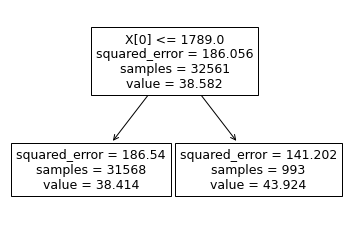

In [78]:
plot_tree(tree_partitioner)

In [114]:
from deepchecks.checks import ModelErrorAnalysis

Model Error Analysis

Find features that best split the data into segments of high and low model error.

Conditions Summary

Status,Condition,More Info
!,The percent change between the performance of detected segments must not exceed 5.00%,Segmentation of error by the features: education resulted in percent change in Accuracy (Default) larger than 5.00%.


Additional Outputs

The following graphs show the distribution of error for top features that are most useful for distinguishing
 high error samples from low error samples.

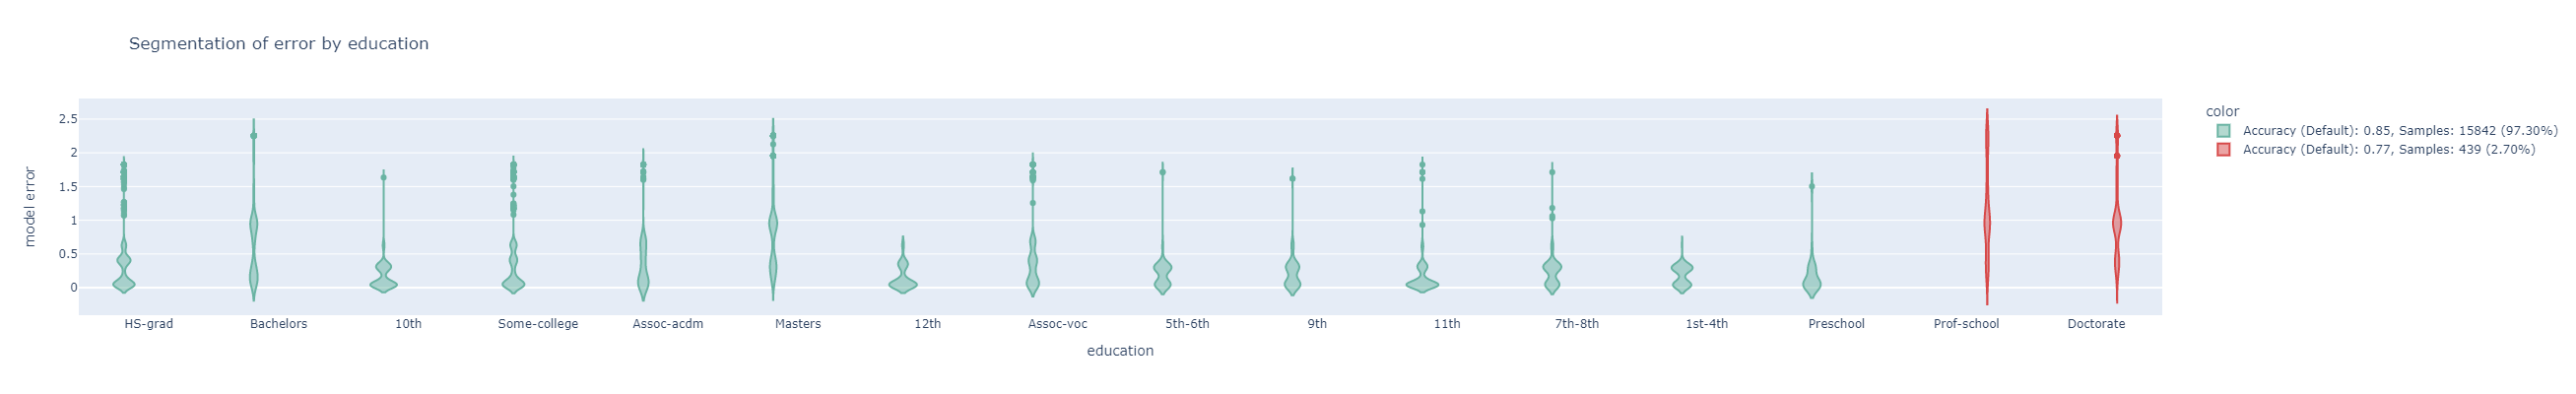

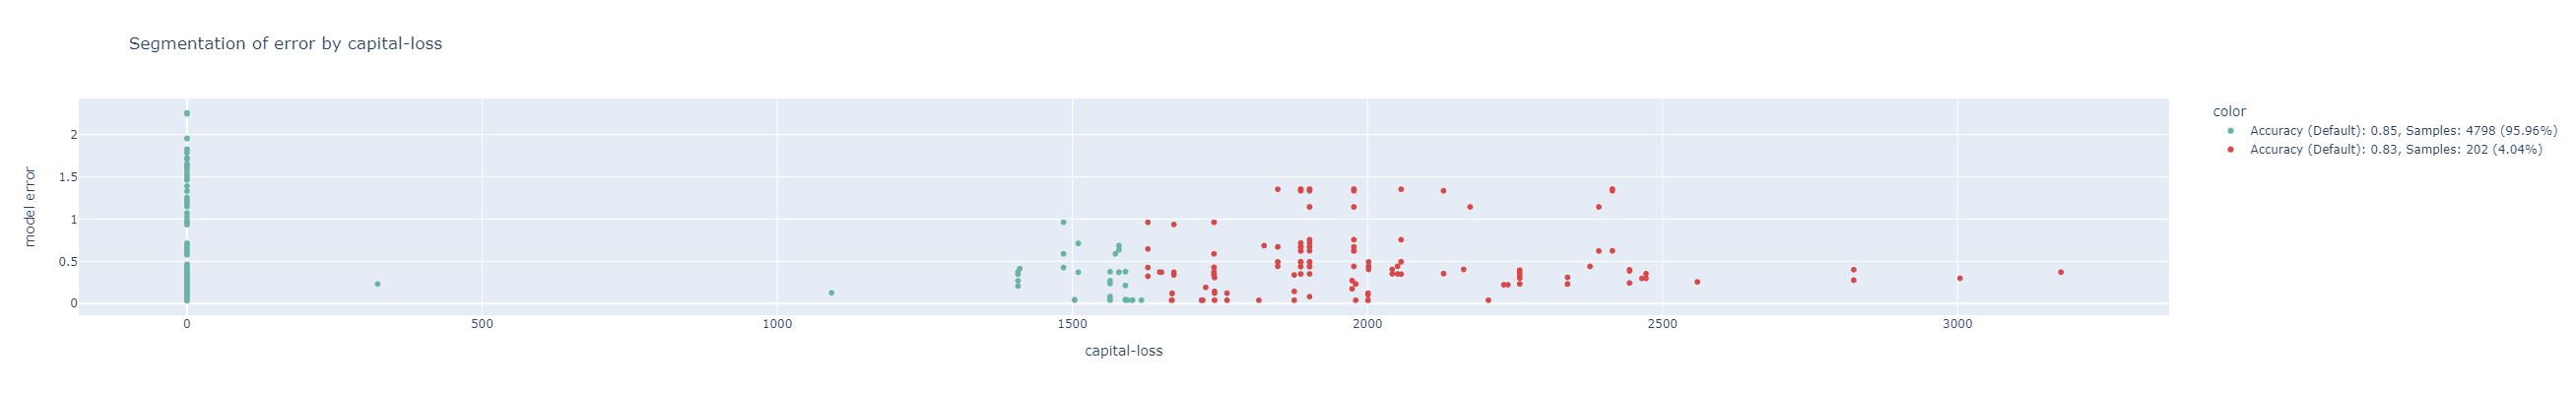

In [142]:
res = ModelErrorAnalysis(min_error_model_score=0.3, min_segment_size=0.04).add_condition_segments_ratio_performance_change_not_greater_than().run(train_ds, validation_ds, model)
res

In [141]:
res.value

{'education': {'segment1': {'score': 0.851912637293271,
   'n_samples': 15842,
   'frac_samples': 0.9730360542964192},
  'segment2': {'score': 0.7699316628701595,
   'n_samples': 439,
   'frac_samples': 0.02696394570358086}},
 'capital-loss': {'segment1': {'score': 0.8316831683168316,
   'n_samples': 202,
   'frac_samples': 0.0404},
  'segment2': {'score': 0.8486869528970404,
   'n_samples': 4798,
   'frac_samples': 0.9596}}}

In [138]:
from deepchecks import Suite

Suite("ModelErrorAnalysis not displayed", ModelErrorAnalysis()).run(train_ds, validation_ds, model)

ModelErrorAnalysis not displayed 
 The suite is composed of the following checks: Model Error Analysis. 
 Each check may contain conditions (which results in 
 ✓ /
 ✖ /
 ! 
 ),
 as well as other outputs such as plots or tables. 
 Suites, checks and conditions can all be modified (see tutorial [link]). 
 Conditions Summary

No conditions defined on checks in the suite.

Additional Outputs

No outputs to show.

Check,Reason
Model Error Analysis,DeepchecksProcessError: Unable to train meaningful error model (r^2 score: 0.42)


Go to top